Training data shape: (74681, 5000)
Validation data shape: (999, 5000)

=== Logistic Regression Metrics ===
Accuracy: 0.8228228228228228
              precision    recall  f1-score   support

  Irrelevant       0.83      0.74      0.78       171
    Negative       0.78      0.89      0.83       266
     Neutral       0.88      0.77      0.82       285
    Positive       0.82      0.86      0.84       277

    accuracy                           0.82       999
   macro avg       0.83      0.82      0.82       999
weighted avg       0.83      0.82      0.82       999



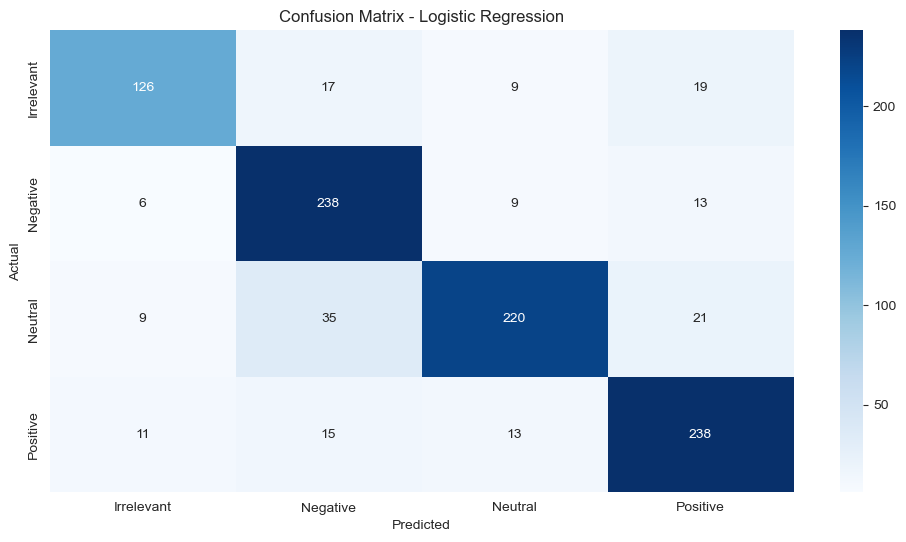


=== Random Forest Metrics ===
Accuracy: 0.9379379379379379
              precision    recall  f1-score   support

  Irrelevant       0.96      0.90      0.93       171
    Negative       0.93      0.95      0.94       266
     Neutral       0.93      0.95      0.94       285
    Positive       0.94      0.94      0.94       277

    accuracy                           0.94       999
   macro avg       0.94      0.93      0.94       999
weighted avg       0.94      0.94      0.94       999



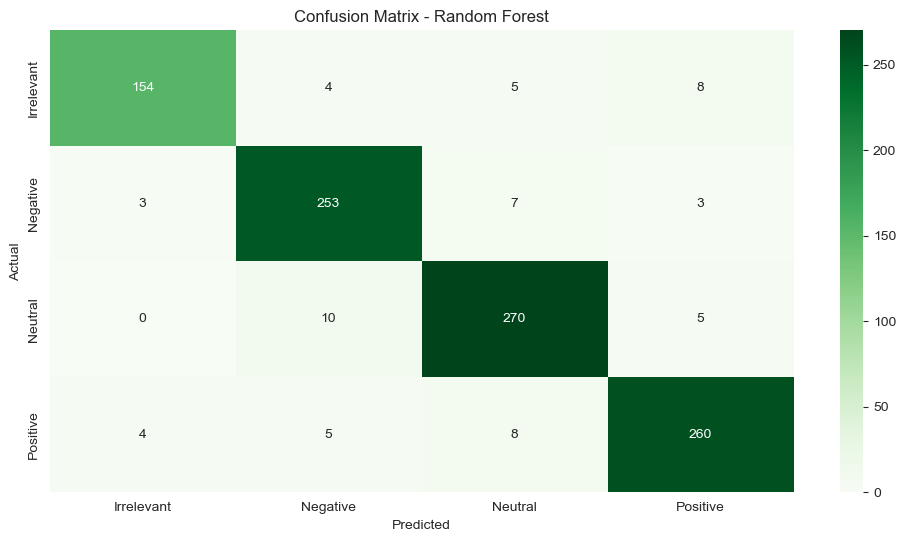

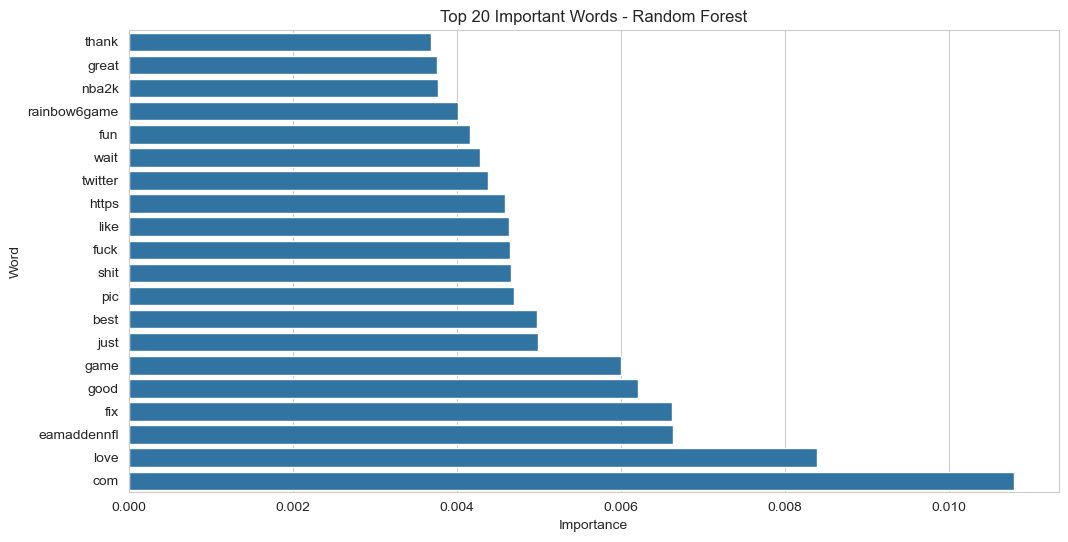

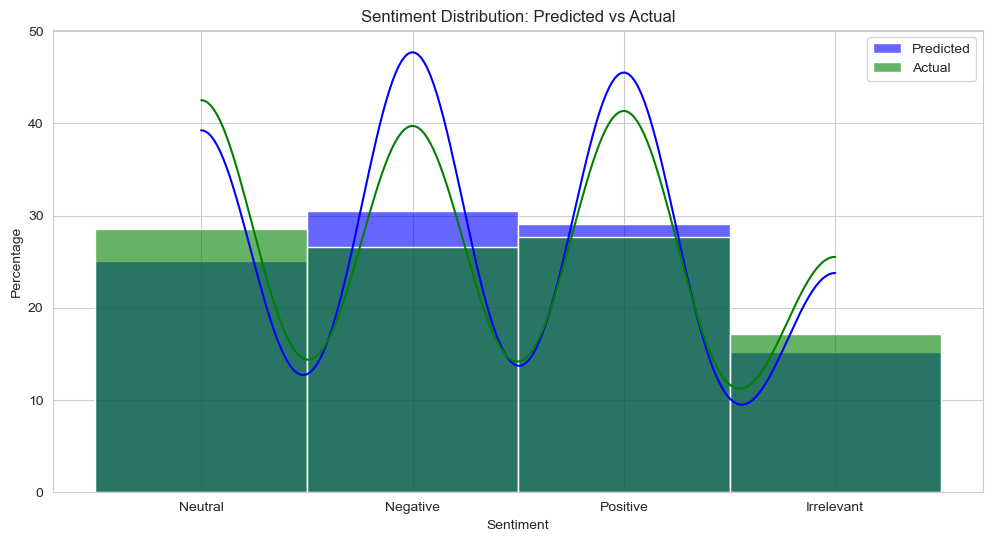

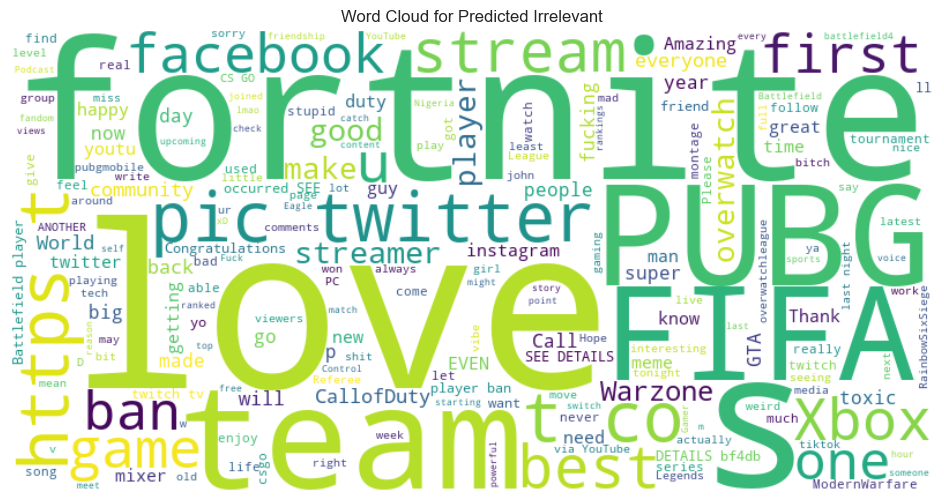

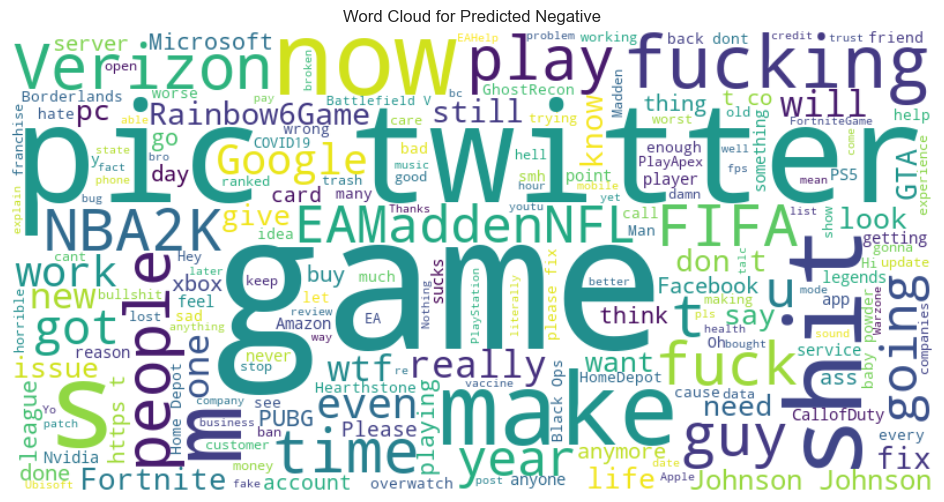

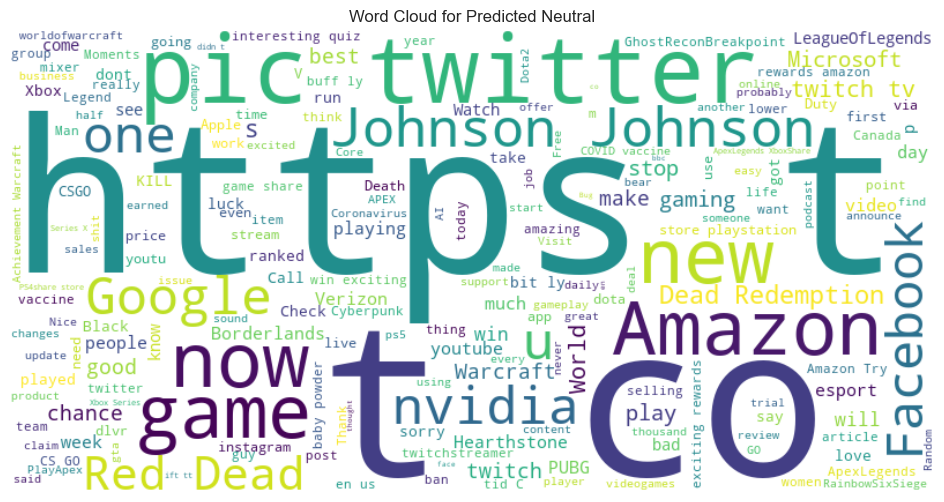

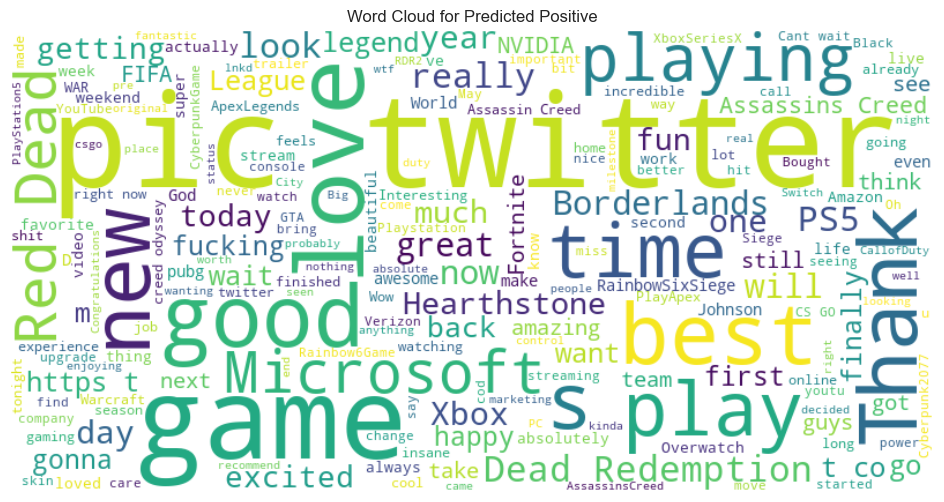

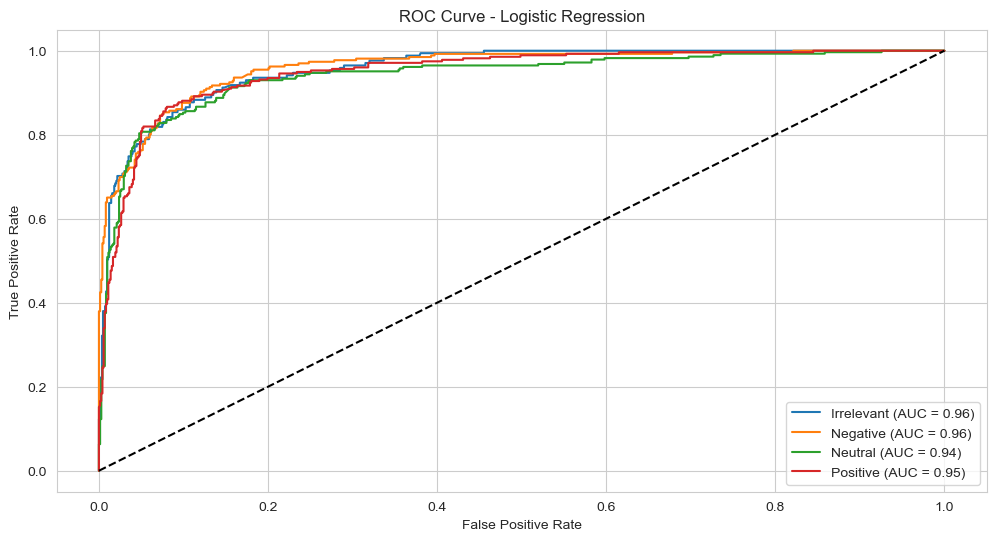

In [3]:
# MODELLING NOTEBOOK CODE FOR TWITTER SENTIMENT ANALYSIS DATASET

# 1. Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')


# For better visuals
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')

# 2. Load and Preprocess Data
# Load datasets
file_path_train = 'archive/twitter_training.csv'
file_path_val = 'archive/twitter_validation.csv'

data_train = pd.read_csv(file_path_train)
data_val = pd.read_csv(file_path_val)

# Rename columns
data_train.columns = ['ID', 'Entity', 'Sentiment', 'Text']
data_val.columns = ['ID', 'Entity', 'Sentiment', 'Text']

# Fill missing values
data_train['Text'] = data_train['Text'].fillna('')
data_val['Text'] = data_val['Text'].fillna('')

# Encode target labels (Sentiment)
label_encoder = LabelEncoder()
data_train['Sentiment_Label'] = label_encoder.fit_transform(data_train['Sentiment'])
data_val['Sentiment_Label'] = label_encoder.transform(data_val['Sentiment'])

# 3. Feature Extraction
# Use TF-IDF Vectorizer to convert text into numerical features
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit on training text and transform both train and validation data
X_train = vectorizer.fit_transform(data_train['Text'])
X_val = vectorizer.transform(data_val['Text'])

# Targets
y_train = data_train['Sentiment_Label']
y_val = data_val['Sentiment_Label']

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

# 4. Model Training
## Logistic Regression
log_clf = LogisticRegression(solver='saga', max_iter=2000, random_state=42)
log_clf.fit(X_train, y_train)

## Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# 5. Model Evaluation
## Predictions
log_pred = log_clf.predict(X_val)
rf_pred = rf_clf.predict(X_val)

# 6. Metrics for Logistic Regression 
print("\n=== Logistic Regression Metrics ===")
print("Accuracy:", accuracy_score(y_val, log_pred))
print(classification_report(y_val, log_pred, target_names=label_encoder.classes_))

# Confusion Matrix
log_cm = confusion_matrix(y_val, log_pred)

# Plot 1: Confusion Matrix - Logistic Regression
plt.figure()
sns.heatmap(log_cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 7. Metrics for Random Forest 
print("\n=== Random Forest Metrics ===")
print("Accuracy:", accuracy_score(y_val, rf_pred))
print(classification_report(y_val, rf_pred, target_names=label_encoder.classes_))

# Confusion Matrix
rf_cm = confusion_matrix(y_val, rf_pred)

# Plot 2: Confusion Matrix - Random Forest
plt.figure()
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 8. Feature Importance from Random Forest 
feature_importances = rf_clf.feature_importances_
# Top 20 features
top_features = np.argsort(feature_importances)[-20:]  

# Plot 3: Top 20 Features
plt.figure()
sns.barplot(x=feature_importances[top_features], y=np.array(vectorizer.get_feature_names_out())[top_features])
plt.title("Top 20 Important Words - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Word")
plt.show()

# 9. Sentiment Distribution Comparison 
# Plot 4: Sentiment Comparison - Predicted vs Actual
pred_labels = label_encoder.inverse_transform(log_pred)
actual_labels = label_encoder.inverse_transform(y_val)

sns.histplot(pred_labels, kde=True, color='blue', label='Predicted', stat='percent', alpha=0.6)
sns.histplot(actual_labels, kde=True, color='green', label='Actual', stat='percent', alpha=0.6)
plt.title("Sentiment Distribution: Predicted vs Actual")
plt.xlabel("Sentiment")
plt.ylabel("Percentage")
plt.legend()
plt.show()

# 10. Word Clouds for Predictions 
for sentiment in label_encoder.classes_:
    pred_indices = (pred_labels == sentiment)
    pred_texts = ' '.join(data_val.loc[pred_indices, 'Text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(pred_texts)
    
    # Plot 5: Word Cloud for Predicted Sentiment
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Predicted {sentiment}")
    plt.show()

# 11. ROC Curve for Logistic Regression 
log_proba = log_clf.predict_proba(X_val)

plt.figure()
for i, sentiment in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_val == i, log_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{sentiment} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.show()
